<a href="https://colab.research.google.com/github/kojikokojiko/portfoilio/blob/master/lightgbm_%26LSTM_2nd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/Kaggle/Predict Future Sales

/content/drive/My Drive/Colab Notebooks/Kaggle/Predict Future Sales


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn import preprocessing
import os
%matplotlib inline


import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error 

In [0]:


# train_dateを取得
items = pd.read_csv('./input/items.csv')
item_categories = pd.read_csv('./input/item_categories.csv')
shops = pd.read_csv('./input/shops.csv')
sales_train = pd.read_csv('./input/sales_train.csv',parse_dates=["date"])
test = pd.read_csv('./input/test.csv')

# １．全データの概要確認



In [45]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [46]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [47]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [48]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [49]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


・ID - an Id that represents a (Shop, Item) tuple within the test set

・shop_id - unique identifier of a shop

・item_id - unique identifier of a product

・item_category_id - unique identifier of item category

・item_cnt_day - number of products sold. You are predicting a 
monthly amount of this measure

・item_price - current price of an item

・date - date in format dd/mm/yyyy

・date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

・item_name - name of item

・shop_name - name of shop

item_category_name - name of item category

# ２.特徴量の作成


## Ⅰ.big_categoryのカラムを作成
item_cagory_nameはPC - Гарнитуры/Наушники	のように
大分類-小分類という記法になっているので、大分類だけで再度まとめる

In [50]:
# ' - 'で文字列分割
item_categories['big_category_name'] = item_categories['item_category_name'].map(lambda x: x.split(' - ')[0])
item_categories['big_category_name'].value_counts()

Книги                                13
Подарки                              12
Игровые консоли                       8
Игры                                  8
Аксессуары                            7
Программы                             6
Музыка                                6
Кино                                  5
Карты оплаты                          4
Игры PC                               4
Служебные                             2
Игры Android                          1
Чистые носители (штучные)             1
Игры MAC                              1
PC                                    1
Чистые носители (шпиль)               1
Доставка товара                       1
Элементы питания                      1
Билеты (Цифра)                        1
Карты оплаты (Кино, Музыка, Игры)     1
Name: big_category_name, dtype: int64

In [51]:
# Чистые носители (штучные)とЧистые носители (шпиль)をЧистые носителиでまとめてしまう
item_categories.loc[
    item_categories['big_category_name']=='Чистые носители (штучные)','big_category_name'
] = 'Чистые носители'


item_categories.loc[
    item_categories['big_category_name']=='Чистые носители (шпиль)','big_category_name'
] = 'Чистые носители'

item_categories['big_category_name'].value_counts()

Книги                                13
Подарки                              12
Игровые консоли                       8
Игры                                  8
Аксессуары                            7
Программы                             6
Музыка                                6
Кино                                  5
Карты оплаты                          4
Игры PC                               4
Служебные                             2
Чистые носители                       2
Игры Android                          1
Игры MAC                              1
PC                                    1
Доставка товара                       1
Элементы питания                      1
Билеты (Цифра)                        1
Карты оплаты (Кино, Музыка, Игры)     1
Name: big_category_name, dtype: int64

In [0]:

# item_category_nameのカラムを消す
item_categories=item_categories.drop('item_category_name',axis=1)

In [53]:
item_categories

,item_category_id,big_category_name
0,0,PC
1,1,Аксессуары
2,2,Аксессуары
3,3,Аксессуары
4,4,Аксессуары
...,...,...
79,79,Служебные
80,80,Служебные
81,81,Чистые носители
82,82,Чистые носители


In [0]:
# itemのDFとマージしてやる
items=items.merge(item_categories)

In [55]:
items

,item_name,item_id,item_category_id,big_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино
...,...,...,...,...
22165,Элемент питания GP 15AU (LR6) - Блистер 2 шт U...,22095,83,Элементы питания
22166,Элемент питания GP 24A (LR03) - Блистер 2 шт,22096,83,Элементы питания
22167,Элемент питания GP 24AU (LR03) - Блистер 2 шт ...,22097,83,Элементы питания
22168,Элемент питания КОСМОС LR03 2*BL,22098,83,Элементы питания


**後々big_category_nameをlabel_encodingすることを忘れないように**





























item_nameはあまり関係なさそうなのでdropする
item_category_idは後々big_categoryでlabel_encodingするので消す

In [0]:
items=items.drop(['item_name','item_category_id'],axis=1)


In [0]:
items

,item_id,big_category_name
0,0,Кино
1,2,Кино
2,3,Кино
3,4,Кино
4,5,Кино
...,...,...
22165,22095,Элементы питания
22166,22096,Элементы питания
22167,22097,Элементы питания
22168,22098,Элементы питания


## Ⅱ.city_nameのカラムを作ってやる

shop_nameは、市名→店名みたいな構成らしい
ので、一番大きい分類である市の情報を使ってやる

shopの名前自体は関係ないだろう、よほどのブランドとかでない限り

In [0]:

shops['city_name'] = shops['shop_name'].map(lambda x: x.split(' ')[0])

shops['city_name'].value_counts()

Москва              13
РостовНаДону         3
Тюмень               3
Воронеж              3
Красноярск           2
Жуковский            2
Якутск               2
Казань               2
СПб                  2
!Якутск              2
Н.Новгород           2
Самара               2
Уфа                  2
Новосибирск          2
Омск                 1
Цифровой             1
Интернет-магазин     1
Балашиха             1
Сургут               1
Томск                1
Волжский             1
Адыгея               1
Химки                1
Ярославль            1
Вологда              1
Коломна              1
Курск                1
Чехов                1
Калуга               1
Сергиев              1
Выездная             1
Мытищи               1
Name: city_name, dtype: int64

In [0]:
# !ЯкутскとЯкутскを一緒にする
shops.loc[shops['city_name']=='!Якутск','city_name'] = 'Якутск'

shops['city_name'].value_counts()

Москва              13
Якутск               4
РостовНаДону         3
Тюмень               3
Воронеж              3
Казань               2
СПб                  2
Уфа                  2
Н.Новгород           2
Красноярск           2
Самара               2
Новосибирск          2
Жуковский            2
Интернет-магазин     1
Цифровой             1
Омск                 1
Сургут               1
Балашиха             1
Томск                1
Волжский             1
Адыгея               1
Химки                1
Ярославль            1
Вологда              1
Коломна              1
Курск                1
Чехов                1
Калуга               1
Сергиев              1
Выездная             1
Мытищи               1
Name: city_name, dtype: int64

In [0]:
shops=shops.drop('shop_name',axis=1)
shops

,shop_id,city_name
0,0,Якутск
1,1,Якутск
2,2,Адыгея
3,3,Балашиха
4,4,Волжский
5,5,Вологда
6,6,Воронеж
7,7,Воронеж
8,8,Воронеж
9,9,Выездная


## Ⅲ.月次shop_id*item_id別売上点数, 月次shop_id*item_id別売上金額のカラムを作ってやる

In [0]:

# 日次売り上げ額
sales_train['date_sales'] = sales_train['item_cnt_day'] * sales_train['item_price']
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_sales
0,2013-02-01,0,59,22154,999.00,1.0,999.00
1,2013-03-01,0,25,2552,899.00,1.0,899.00
2,2013-05-01,0,25,2552,899.00,-1.0,-899.00
3,2013-06-01,0,25,2554,1709.05,1.0,1709.05
4,2013-01-15,0,25,2555,1099.00,1.0,1099.00
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,299.00
2935845,2015-09-10,33,25,7460,299.00,1.0,299.00
2935846,2015-10-14,33,25,7459,349.00,1.0,349.00
2935847,2015-10-22,33,25,7440,299.00,1.0,299.00


In [0]:
# 月次shop_id*item_id別売上点数のカラムを作る
mon_shop_item_cnt = sales_train[
    ['date_block_num','shop_id','item_id','item_cnt_day']
].groupby(
    ['date_block_num','shop_id','item_id'],
    as_index=False
).sum().rename(columns={'item_cnt_day':'mon_shop_item_cnt'})
mon_shop_item_cnt

,date_block_num,shop_id,item_id,mon_shop_item_cnt
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609119,33,59,22087,6.0
1609120,33,59,22088,2.0
1609121,33,59,22091,1.0
1609122,33,59,22100,1.0


In [0]:
# 月次shop_id*item_id別金額の平均のカラムを作る
mon_shop_item_price = sales_train[
    ['date_block_num','shop_id','item_id','item_price']
].groupby(
    ['date_block_num','shop_id','item_id'],
    as_index=False
).mean().rename(columns={'item_price':'mon_shop_item_price'})
mon_shop_item_price

,date_block_num,shop_id,item_id,mon_shop_item_price
0,0,0,32,221.0
1,0,0,33,347.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,128.5
...,...,...,...,...
1609119,33,59,22087,119.0
1609120,33,59,22088,119.0
1609121,33,59,22091,179.0
1609122,33,59,22100,629.0


In [0]:
items

In [0]:
shops.head()

## Ⅴ.trainデータを作成していく

In [0]:
# テストデータセットに含まれる店舗ID×商品ID、かつ、月のシーケンス(date_block_num)が0~34の組み合わせを生成する


train_full_comb = pd.DataFrame()
for i in range(35):
    mid = test[['shop_id','item_id']]
    mid['date_block_num'] = i
    train_full_comb = pd.concat([train_full_comb,mid],axis=0)

In [0]:
train_full_comb

,shop_id,item_id,date_block_num
0,5,5037,0
1,5,5320,0
2,5,5233,0
3,5,5232,0
4,5,5268,0
...,...,...,...
214195,45,18454,34
214196,45,16188,34
214197,45,15757,34
214198,45,19648,34


In [0]:
# 月次売上商品数をマージ
train_test = pd.merge(
    train_full_comb,
    mon_shop_item_cnt,
    on=['date_block_num','shop_id','item_id'],
    how='left'
)



In [0]:
train_test['mon_shop_item_cnt'].unique()

In [0]:
train_test

,shop_id,item_id,date_block_num,mon_shop_item_cnt
0,5,5037,0,NaN
1,5,5320,0,NaN
2,5,5233,0,NaN
3,5,5232,0,NaN
4,5,5268,0,NaN
...,...,...,...,...
7496995,45,18454,34,NaN
7496996,45,16188,34,NaN
7496997,45,15757,34,NaN
7496998,45,19648,34,NaN


In [0]:

# 学習データにマスタをマージ
# item_idのjoin
train_test = pd.merge(
    train_test,
    items[['item_id','big_category_name']],
    on='item_id',
    how='left'
)

In [0]:
train_test

,shop_id,item_id,date_block_num,mon_shop_item_cnt,big_category_name
0,5,5037,0,NaN,Игры
1,5,5320,0,NaN,Музыка
2,5,5233,0,NaN,Игры
3,5,5232,0,NaN,Игры
4,5,5268,0,NaN,Игры
...,...,...,...,...,...
7496995,45,18454,34,NaN,Музыка
7496996,45,16188,34,NaN,Подарки
7496997,45,15757,34,NaN,Музыка
7496998,45,19648,34,NaN,Кино


In [0]:
# shop_idのjoin
train_test = pd.merge(
    train_test,
    shops[['shop_id','city_name']],
    on='shop_id',
    how='left'
)

In [0]:
train_test=pd.merge(
    train_test,
   mon_shop_item_price[['shop_id','item_id','date_block_num','mon_shop_item_price']],
    on=['shop_id','item_id','date_block_num'],
    how='left'
)

ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [0]:
train_test


,shop_id,item_id,date_block_num,mon_shop_item_cnt,big_category_name,city_name,mon_shop_item_price
0,5,5037,0,NaN,Игры,Вологда,NaN
1,5,5320,0,NaN,Музыка,Вологда,NaN
2,5,5233,0,NaN,Игры,Вологда,NaN
3,5,5232,0,NaN,Игры,Вологда,NaN
4,5,5268,0,NaN,Игры,Вологда,NaN
...,...,...,...,...,...,...,...
7496995,45,18454,34,NaN,Музыка,Самара,NaN
7496996,45,16188,34,NaN,Подарки,Самара,NaN
7496997,45,15757,34,NaN,Музыка,Самара,NaN
7496998,45,19648,34,NaN,Кино,Самара,NaN


In [0]:
train_test

,shop_id,item_id,date_block_num,mon_shop_item_cnt,big_category_name,city_name,mon_shop_item_price
0,5,5037,0,NaN,Игры,Вологда,NaN
1,5,5320,0,NaN,Музыка,Вологда,NaN
2,5,5233,0,NaN,Игры,Вологда,NaN
3,5,5232,0,NaN,Игры,Вологда,NaN
4,5,5268,0,NaN,Игры,Вологда,NaN
...,...,...,...,...,...,...,...
7496995,45,18454,34,NaN,Музыка,Самара,NaN
7496996,45,16188,34,NaN,Подарки,Самара,NaN
7496997,45,15757,34,NaN,Музыка,Самара,NaN
7496998,45,19648,34,NaN,Кино,Самара,NaN


True target values are clipped into [0,20] range.

という記述がKaggle側にあったので、mon_shop_item_cntの範囲を0から20に指定

In [0]:
train_test['mon_shop_item_cnt'] = train_test['mon_shop_item_cnt'].clip(0,20)

In [0]:
from sklearn.preprocessing import LabelEncoder

train_test['type_code']=LabelEncoder().fit_transform(train_test['big_category_name'])
train_test['city_code']=LabelEncoder().fit_transform(train_test['city_name'])

In [0]:
train_test.drop(['big_category_name','city_name'],axis=1,inplace=True)

In [0]:
train_test

,shop_id,item_id,date_block_num,mon_shop_item_cnt,mon_shop_item_price,type_code,city_code
0,5,5037,0,NaN,NaN,4,3
1,5,5320,0,NaN,NaN,11,3
2,5,5233,0,NaN,NaN,4,3
3,5,5232,0,NaN,NaN,4,3
4,5,5268,0,NaN,NaN,4,3
...,...,...,...,...,...,...,...
7496995,45,18454,34,NaN,NaN,11,18
7496996,45,16188,34,NaN,NaN,12,18
7496997,45,15757,34,NaN,NaN,11,18
7496998,45,19648,34,NaN,NaN,9,18


In [0]:
# pklデータに落とし込む
train_test.to_pickle('train_test.pkl')

#こっから再開

In [0]:
# pklデータを読み込む
matrix=pd.read_pickle('train_test.pkl')

In [6]:
matrix

,shop_id,item_id,date_block_num,mon_shop_item_cnt,mon_shop_item_price,type_code,city_code
0,5,5037,0,NaN,NaN,4,3
1,5,5320,0,NaN,NaN,11,3
2,5,5233,0,NaN,NaN,4,3
3,5,5232,0,NaN,NaN,4,3
4,5,5268,0,NaN,NaN,4,3
...,...,...,...,...,...,...,...
7496995,45,18454,34,NaN,NaN,11,18
7496996,45,16188,34,NaN,NaN,12,18
7496997,45,15757,34,NaN,NaN,11,18
7496998,45,19648,34,NaN,NaN,9,18


In [0]:
# 関数を使いまわしたいので、カラム名を変更
matrix.rename(columns={'mon_shop_item_cnt':'item_cnt_month'},inplace=True)

In [8]:
matrix

,shop_id,item_id,date_block_num,item_cnt_month,mon_shop_item_price,type_code,city_code
0,5,5037,0,NaN,NaN,4,3
1,5,5320,0,NaN,NaN,11,3
2,5,5233,0,NaN,NaN,4,3
3,5,5232,0,NaN,NaN,4,3
4,5,5268,0,NaN,NaN,4,3
...,...,...,...,...,...,...,...
7496995,45,18454,34,NaN,NaN,11,18
7496996,45,16188,34,NaN,NaN,12,18
7496997,45,15757,34,NaN,NaN,11,18
7496998,45,19648,34,NaN,NaN,9,18


### ラグ特徴量作成


In [0]:
# lag特徴量を作る関数の作成
def lag_feature(df,lags,col):
  tmp=df[['date_block_num','shop_id','item_id',col]]
  for i in lags:
    shifted=tmp.copy()
    shifted.columns=['date_block_num','shop_id','item_id',col+'_lag_'+str(i)]
    shifted['date_block_num']+=i
    df=pd.merge(df,shifted,on=['date_block_num','shop_id','item_id'],how='left')
  return df

In [0]:
# item_cnt_monthのラグを取る
matrix=lag_feature(matrix,[1,2,3,6,12],'item_cnt_month')


In [11]:
matrix

,shop_id,item_id,date_block_num,item_cnt_month,mon_shop_item_price,type_code,city_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,5,5037,0,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN
1,5,5320,0,NaN,NaN,11,3,NaN,NaN,NaN,NaN,NaN
2,5,5233,0,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN
3,5,5232,0,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN
4,5,5268,0,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7496995,45,18454,34,NaN,NaN,11,18,1.0,NaN,NaN,NaN,NaN
7496996,45,16188,34,NaN,NaN,12,18,NaN,NaN,NaN,NaN,NaN
7496997,45,15757,34,NaN,NaN,11,18,NaN,NaN,NaN,NaN,NaN
7496998,45,19648,34,NaN,NaN,9,18,NaN,NaN,NaN,NaN,NaN


###様々な特徴量を組み合わせてそのラグを取る

In [0]:
# 月ごとに一日何個売れたかの平均を取る
group=matrix.groupby(['date_block_num']).agg({'item_cnt_month':['mean']})
group.columns=['date_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num'],how='left')
matrix=lag_feature(matrix,[1,2,3,6,12],'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊item_idごとの平均を取る
group=matrix.groupby(['date_block_num','item_id']).agg({'item_cnt_month':['mean']})
group.columns=['date_item_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','item_id'],how='left')
matrix=lag_feature(matrix,[1,2,3,6,12],'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊shop_idごとの平均を取る
group=matrix.groupby(['date_block_num','shop_id']).agg({'item_cnt_month':['mean']})
group.columns=['date_shop_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','shop_id'],how='left')
matrix=lag_feature(matrix,[1,2,3,6,12],'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊shop_id*type_codeごとの平均を取る
group=matrix.groupby(['date_block_num','shop_id','type_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','shop_id','type_code'],how='left')
matrix=lag_feature(matrix,[1,2,3,6,12],'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊city_codeごとの平均を取る
group=matrix.groupby(['date_block_num','city_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_city_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','city_code'],how='left')
matrix=lag_feature(matrix,[1,2,3,6,12],'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊type_codeごとの平均を取る
group=matrix.groupby(['date_block_num','type_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_type_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','type_code'],how='left')
matrix=lag_feature(matrix,[1,2,3,6,12],'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊item_id*city_codeごとの平均を取る
group=matrix.groupby(['date_block_num','item_id','city_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_item_city_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','item_id','city_code'],how='left')
matrix=lag_feature(matrix,[1,2,3,6,12],'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'],axis=1,inplace=True)

In [0]:
# date_block_num＊type_code*city_codeごとの平均を取る
group=matrix.groupby(['date_block_num','type_code','city_code']).agg({'item_cnt_month':['mean']})
group.columns=['date_type_city_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','type_code','city_code'],how='left')
matrix=lag_feature(matrix,[1,2,3,6,12],'date_type_city_avg_item_cnt')
matrix.drop(['date_type_city_avg_item_cnt'],axis=1,inplace=True)

In [20]:
matrix

,shop_id,item_id,date_block_num,item_cnt_month,mon_shop_item_price,type_code,city_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_6,date_avg_item_cnt_lag_12,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_12,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_12,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_6,date_type_avg_item_cnt_lag_12,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_12,date_type_city_avg_item_cnt_lag_1,date_type_city_avg_item_cnt_lag_2,date_type_city_avg_item_cnt_lag_3,date_type_city_avg_item_cnt_lag_6,date_type_city_avg_item_cnt_lag_12
0,5,5037,0,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,5320,0,NaN,NaN,11,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,5233,0,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,5232,0,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5268,0,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496995,45,18454,34,NaN,NaN,11,18,1.0,NaN,NaN,NaN,NaN,1.909344,1.993053,1.923276,1.971053,2.437444,1.0,1.00,1.0,1.333333,NaN,1.49217,1.612403,1.435165,1.547315,2.080685,1.197368,1.243902,1.166667,1.323077,1.470588,1.462963,1.551208,1.409563,1.547382,2.019441,1.348497,1.284499,1.289798,1.358161,1.547123,1.0,NaN,NaN,NaN,NaN,1.205556,1.181159,1.113475,1.285714,1.348837
7496996,45,16188,34,NaN,NaN,12,18,NaN,NaN,NaN,NaN,NaN,1.909344,1.993053,1.923276,1.971053,2.437444,1.0,1.00,NaN,NaN,NaN,1.49217,1.612403,1.435165,1.547315,2.080685,1.493827,1.471429,1.237113,1.537313,1.846154,1.462963,1.551208,1.409563,1.547382,2.019441,1.760115,1.796292,1.777778,1.878922,2.150773,NaN,NaN,NaN,NaN,NaN,1.462366,1.359281,1.240196,1.467456,1.734266
7496997,45,15757,34,NaN,NaN,11,18,NaN,NaN,NaN,NaN,NaN,1.909344,1.993053,1.923276,1.971053,2.437444,1.0,1.00,1.0,1.250000,1.0,1.49217,1.612403,1.435165,1.547315,2.080685,1.197368,1.243902,1.166667,1.323077,1.470588,1.462963,1.551208,1.409563,1.547382,2.019441,1.348497,1.284499,1.289798,1.358161,1.547123,NaN,1.0,NaN,NaN,NaN,1.205556,1.181159,1.113475,1.285714,1.348837
7496998,45,19648,34,NaN,NaN,9,18,NaN,NaN,NaN,NaN,NaN,1.909344,1.993053,1.923276,1.971053,2.437444,1.0,1.00,1.2,1.000000,NaN,1.49217,1.612403,1.435165,1.547315,2.080685,1.215686,1.192308,1.285714,1.214286,1.295775,1.462963,1.551208,1.409563,1.547382,2.019441,1

In [0]:
# item_priceを別の方法で反映させたいので、いったん消す
matrix.drop('mon_shop_item_price',axis=1,inplace=True)

In [22]:
matrix

,shop_id,item_id,date_block_num,item_cnt_month,type_code,city_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_6,date_avg_item_cnt_lag_12,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_12,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_12,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_6,date_type_avg_item_cnt_lag_12,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_12,date_type_city_avg_item_cnt_lag_1,date_type_city_avg_item_cnt_lag_2,date_type_city_avg_item_cnt_lag_3,date_type_city_avg_item_cnt_lag_6,date_type_city_avg_item_cnt_lag_12
0,5,5037,0,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,5320,0,NaN,11,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,5233,0,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,5232,0,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5268,0,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496995,45,18454,34,NaN,11,18,1.0,NaN,NaN,NaN,NaN,1.909344,1.993053,1.923276,1.971053,2.437444,1.0,1.00,1.0,1.333333,NaN,1.49217,1.612403,1.435165,1.547315,2.080685,1.197368,1.243902,1.166667,1.323077,1.470588,1.462963,1.551208,1.409563,1.547382,2.019441,1.348497,1.284499,1.289798,1.358161,1.547123,1.0,NaN,NaN,NaN,NaN,1.205556,1.181159,1.113475,1.285714,1.348837
7496996,45,16188,34,NaN,12,18,NaN,NaN,NaN,NaN,NaN,1.909344,1.993053,1.923276,1.971053,2.437444,1.0,1.00,NaN,NaN,NaN,1.49217,1.612403,1.435165,1.547315,2.080685,1.493827,1.471429,1.237113,1.537313,1.846154,1.462963,1.551208,1.409563,1.547382,2.019441,1.760115,1.796292,1.777778,1.878922,2.150773,NaN,NaN,NaN,NaN,NaN,1.462366,1.359281,1.240196,1.467456,1.734266
7496997,45,15757,34,NaN,11,18,NaN,NaN,NaN,NaN,NaN,1.909344,1.993053,1.923276,1.971053,2.437444,1.0,1.00,1.0,1.250000,1.0,1.49217,1.612403,1.435165,1.547315,2.080685,1.197368,1.243902,1.166667,1.323077,1.470588,1.462963,1.551208,1.409563,1.547382,2.019441,1.348497,1.284499,1.289798,1.358161,1.547123,NaN,1.0,NaN,NaN,NaN,1.205556,1.181159,1.113475,1.285714,1.348837
7496998,45,19648,34,NaN,9,18,NaN,NaN,NaN,NaN,NaN,1.909344,1.993053,1.923276,1.971053,2.437444,1.0,1.00,1.2,1.000000,NaN,1.49217,1.612403,1.435165,1.547315,2.080685,1.215686,1.192308,1.285714,1.214286,1.295775,1.462963,1.551208,1.409563,1.547382,2.019441,1.656067,1.617451,1.631481,1.786065,1.720622,NaN,NaN,NaN,NaN,

In [0]:
# item_idごとにitem_priceの平均を取る
group=sales_train.groupby(['item_id']).agg({'item_price':['mean']})
group.columns=['item_avg_item_price']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['item_id'],how='left')


In [0]:
# date_block_num*item_idごとのitem_priceの平均をもとめる
group=sales_train.groupby(['date_block_num','item_id']).agg({'item_price':['mean']})
group.columns=['date_item_avg_item_price']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','item_id'],how='left')


In [0]:
# trainデータ全体から、item_idごとにitem_priceの平均を取ったものと、月ごとitem_idごとにitem_priceの平均を取ったものとの誤差率をだす
matrix['dif_date_item_price']=  (matrix['date_item_avg_item_price'] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']


In [0]:
# ラグを取る
matrix=lag_feature(matrix,[1,2,3,6,12],'dif_date_item_price')

In [0]:
# pklデータに落とし込む
matrix.to_pickle('matrix.pkl')

In [0]:
# pklデータを読み込む
matrix=pd.read_pickle('matrix.pkl')

In [31]:
matrix

,shop_id,item_id,date_block_num,item_cnt_month,type_code,city_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_6,date_avg_item_cnt_lag_12,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_12,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_12,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_6,date_type_avg_item_cnt_lag_12,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_12,date_type_city_avg_item_cnt_lag_1,date_type_city_avg_item_cnt_lag_2,date_type_city_avg_item_cnt_lag_3,date_type_city_avg_item_cnt_lag_6,date_type_city_avg_item_cnt_lag_12,item_avg_item_price,date_item_avg_item_price,dif_date_item_price,dif_date_item_price_lag_1,dif_date_item_price_lag_2,dif_date_item_price_lag_3,dif_date_item_price_lag_6,dif_date_item_price_lag_12
0,5,5037,0,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1926.828388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,5320,0,NaN,11,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,5233,0,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,800.777500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,5232,0,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,790.512923,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5268,0,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496995,45,18454,34,NaN,11,18,1.0,NaN,NaN,NaN,NaN,1.909344,1.993053,1.923276,1.971053,2.437444,1.0,1.00,1.0,1.333333,NaN,1.49217,1.612403,1.435165,1.547315,2.080685,1.197368,1.243902,1.166667,1.323077,1.470588,1.462963,1.551208,1.409563,1.547382,2.019441,1.348497,1.284499,1.289798,1.358161,1.547123,1.0,NaN,NaN,NaN,NaN,1.205556,1.181159,1.113475,1.285714,1.348837,188.681084,NaN,NaN,-0.475305,-0.475305,-0.475305,0.054690,NaN
7496996,45,16188,34,NaN,12,18,NaN,NaN,NaN,NaN,NaN,1.909344,1.993053,1.923276,1.971053,2.437444,1.0,1.00,NaN,NaN,NaN,1.49217,1.612403,1.435165,1.547315,2.080685,1.493827,1.471429,1.237113,1.537313,1.846154,1.462963,1.551208,1.409563,1.547382,2.019441,1.760115,1.796292,1.777778,1.878922,2.150773,NaN,NaN,NaN,NaN,NaN,1.462366,1.359281,1.240196,1.467456,1.734266,1256.975000,NaN,NaN,0.081167,-0.027056,NaN,NaN,NaN
7496997,45,15757,34,NaN,11,18,NaN,NaN,NaN,NaN,NaN,1.909344,1.993053,1.923276,1.971053,2.437444,1.0,1.00,1.0,1.250000,1.0,1.49217,1.612403,1.435165,1.547315,2

大枠は完成、あとは
##細かな処理

In [0]:
# 月を記述
matrix['month']=matrix['date_block_num']%12

In [0]:
# 月の日数を示すカラムを追加
days=pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days']=matrix['month'].map(days)

In [0]:
# 12か月まえまでのラグを取っているので、date_block_numの0~11までを消してやる
matrix=matrix[matrix['date_block_num']>11]


In [35]:
matrix.fillna(0,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [36]:
matrix

,shop_id,item_id,date_block_num,item_cnt_month,type_code,city_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_avg_item_cnt_lag_2,date_avg_item_cnt_lag_3,date_avg_item_cnt_lag_6,date_avg_item_cnt_lag_12,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_shop_type_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_6,date_shop_type_avg_item_cnt_lag_12,date_city_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_6,date_city_avg_item_cnt_lag_12,date_type_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_6,date_type_avg_item_cnt_lag_12,date_item_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_6,date_item_city_avg_item_cnt_lag_12,date_type_city_avg_item_cnt_lag_1,date_type_city_avg_item_cnt_lag_2,date_type_city_avg_item_cnt_lag_3,date_type_city_avg_item_cnt_lag_6,date_type_city_avg_item_cnt_lag_12,item_avg_item_price,date_item_avg_item_price,dif_date_item_price,dif_date_item_price_lag_1,dif_date_item_price_lag_2,dif_date_item_price_lag_3,dif_date_item_price_lag_6,dif_date_item_price_lag_12,month,days
2570400,5,5037,12,0.0,4,3,0.0,0.0,0.0,0.0,0.0,3.183057,2.708398,2.564540,2.270302,2.484118,0.0,0.00,0.0,0.000000,0.0,2.620253,2.112450,1.896996,1.833333,0.000000,3.507937,2.750000,2.864865,1.600000,0.000000,2.620253,2.112450,1.896996,1.833333,0.000000,4.877453,3.562264,3.825699,2.796572,2.874564,0.0,0.0,0.0,0.0,0.0,3.507937,2.750000,2.864865,1.600000,0.000000,1926.828388,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,31
2570401,5,5320,12,0.0,11,3,0.0,0.0,0.0,0.0,0.0,3.183057,2.708398,2.564540,2.270302,2.484118,0.0,0.00,0.0,0.000000,0.0,2.620253,2.112450,1.896996,1.833333,0.000000,1.769231,1.333333,1.129870,1.387755,0.000000,2.620253,2.112450,1.896996,1.833333,0.000000,1.809678,1.547413,1.456320,1.527744,1.579821,0.0,0.0,0.0,0.0,0.0,1.769231,1.333333,1.129870,1.387755,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,31
2570402,5,5233,12,0.0,4,3,0.0,0.0,0.0,0.0,0.0,3.183057,2.708398,2.564540,2.270302,2.484118,0.0,0.00,0.0,0.000000,0.0,2.620253,2.112450,1.896996,1.833333,0.000000,3.507937,2.750000,2.864865,1.600000,0.000000,2.620253,2.112450,1.896996,1.833333,0.000000,4.877453,3.562264,3.825699,2.796572,2.874564,0.0,0.0,0.0,0.0,0.0,3.507937,2.750000,2.864865,1.600000,0.000000,800.777500,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,31
2570403,5,5232,12,0.0,4,3,0.0,0.0,0.0,0.0,0.0,3.183057,2.708398,2.564540,2.270302,2.484118,0.0,0.00,0.0,0.000000,0.0,2.620253,2.112450,1.896996,1.833333,0.000000,3.507937,2.750000,2.864865,1.600000,0.000000,2.620253,2.112450,1.896996,1.833333,0.000000,4.877453,3.562264,3.825699,2.796572,2.874564,0.0,0.0,0.0,0.0,0.0,3.507937,2.750000,2.864865,1.600000,0.000000,790.512923,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,31
2570404,5,5268,12,0.0,4,3,0.0,0.0,0.0,0.0,0.0,3.183057,2.708398,2.564540,2.270302,2.484118,0.0,0.00,0.0,0.000000,0.0,2.620253,2.112450,1.896996,1.833333,0.000000,3.507937,2.750000,2.864865,1.600000,0.000000,2.620253,2.112450,1.896996,1.833333,0.000000,4.877453,3.562264,3.825699,2.796572,2.874564,0.0,0.0,0.0,0.0,0.0,3.507937,2.750000,2.864865,1.600000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7

In [38]:
matrix.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'type_code',
       'city_code', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_avg_item_cnt_lag_2',
       'date_avg_item_cnt_lag_3', 'date_avg_item_cnt_lag_6',
       'date_avg_item_cnt_lag_12', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_12',
       'date_shop_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_avg_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_6',
       'date_shop_avg_item_cnt_lag_12', 'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_2',
       'date_shop_type_avg_item_cnt_lag_3',
       'date_shop_type_avg_item_cnt_lag_6',
       'date_shop_type_avg_item_cnt_lag_12', 'date_city_avg_item_cnt_lag_1',
       'date_c

In [0]:
data=matrix[['shop_id',
             'item_id', 
             'date_block_num', 
             'item_cnt_month', 
             'type_code',
             'city_code',   
             'item_cnt_month_lag_1', 
             'item_cnt_month_lag_2',
             'item_cnt_month_lag_3', 
             'item_cnt_month_lag_6', 
             'item_cnt_month_lag_12',
             'date_avg_item_cnt_lag_1',  
             'date_avg_item_cnt_lag_2',
             'date_avg_item_cnt_lag_3', 
             'date_avg_item_cnt_lag_6',
             'date_avg_item_cnt_lag_12', 
             'date_item_avg_item_cnt_lag_1',
             'date_item_avg_item_cnt_lag_2', 
             'date_item_avg_item_cnt_lag_3',
             'date_item_avg_item_cnt_lag_6', 
             'date_item_avg_item_cnt_lag_12',
             'date_shop_avg_item_cnt_lag_1', 
             'date_shop_avg_item_cnt_lag_2',
             'date_shop_avg_item_cnt_lag_3',  
             'date_shop_avg_item_cnt_lag_6',
             'date_shop_avg_item_cnt_lag_12', 
             'date_shop_type_avg_item_cnt_lag_1',
             'date_shop_type_avg_item_cnt_lag_2',
             'date_shop_type_avg_item_cnt_lag_3',
             'date_shop_type_avg_item_cnt_lag_6',
             'date_shop_type_avg_item_cnt_lag_12',  
             'date_city_avg_item_cnt_lag_1',
             'date_city_avg_item_cnt_lag_2', 
             'date_city_avg_item_cnt_lag_3',
             'date_city_avg_item_cnt_lag_6', 
             'date_city_avg_item_cnt_lag_12',
             'date_type_avg_item_cnt_lag_1', 
             'date_type_avg_item_cnt_lag_2',
             'date_type_avg_item_cnt_lag_3', 
             'date_type_avg_item_cnt_lag_6',
             'date_type_avg_item_cnt_lag_12', 
             'date_item_city_avg_item_cnt_lag_1',
             'date_item_city_avg_item_cnt_lag_2',
             'date_item_city_avg_item_cnt_lag_3',
             'date_item_city_avg_item_cnt_lag_6',
             'date_item_city_avg_item_cnt_lag_12',
             'date_type_city_avg_item_cnt_lag_1',
             'date_type_city_avg_item_cnt_lag_2',
             'date_type_city_avg_item_cnt_lag_3',
             'date_type_city_avg_item_cnt_lag_6',
             'date_type_city_avg_item_cnt_lag_12', 
            #  'item_avg_item_price',
            #  'date_item_avg_item_price', 
            #  'dif_date_item_price',
            #  'dif_date_item_price_lag_1', 
            #  'dif_date_item_price_lag_2',
            #  'dif_date_item_price_lag_3', 
            #  'dif_date_item_price_lag_6',
            #  'dif_date_item_price_lag_12', 
             'month', 
             'days'
             
             ]
            
            




]

In [0]:
# pklデータに落とし込む
data.to_pickle('data.pkl')

In [0]:
# pklデータを読み込む
data=pd.read_pickle('data.pkl')

###訓練、検証、テストデータ分け

In [0]:
X_train=data[data.date_block_num<33].drop(['item_cnt_month'],axis=1)
y_train=data[data.date_block_num<33]['item_cnt_month']
X_valid=data[data.date_block_num==33].drop(['item_cnt_month'],axis=1)
y_valid=data[data.date_block_num==33]['item_cnt_month']
X_test=data[data.date_block_num==34].drop(['item_cnt_month'],axis=1)



## model構築

In [0]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid)

In [84]:
# パラメータサーチ
RMSE_list = []
count = []
for i in range(6, 13):
    params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'max_depth' : i}
    
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_eval,
                early_stopping_rounds=10,
                verbose_eval=50)
    
    predicted = gbm.predict(X_valid)
    pred_df = pd.concat([y_valid.reset_index(drop=True), pd.Series(predicted)], axis=1)
    pred_df.columns = ['true', 'pred']
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    RMSE_list.append(RMSE)
    count.append(i)

Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[29]	valid_0's rmse: 0.881143
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's rmse: 0.880084
Early stopping, best iteration is:
[54]	valid_0's rmse: 0.879811
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's rmse: 0.881939
Early stopping, best iteration is:
[41]	valid_0's rmse: 0.881459
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's rmse: 0.882601
Early stopping, best iteration is:
[58]	valid_0's rmse: 0.882205
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's rmse: 0.882864
Early stopping, best iteration is:
[71]	valid_0's rmse: 0.881327
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's rmse: 0.882065
Early stopping, best iteration is:
[50]	valid_0's rmse: 0.882065
Training until validation scores don't improve for 10 rounds.
[50]	valid_0's rmse: 0.882

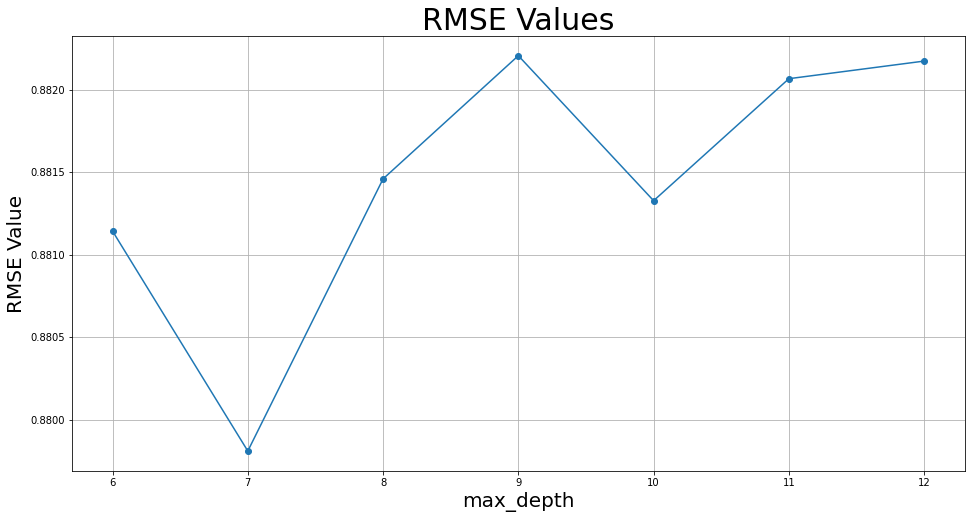

In [85]:
plt.figure(figsize=(16,8))
plt.plot(count, RMSE_list, marker="o")
plt.title("RMSE Values", fontsize=30)
plt.xlabel("max_depth", fontsize=20)
plt.ylabel("RMSE Value", fontsize=20)
plt.grid(True)

max_depth＝7で実装していく

In [86]:
params = {'boosting_type': 'gbdt',
         'objective': 'regression',
          'metric': 'rmse',
          'max_depth' : 7}
    

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=lgb_eval,
                early_stopping_rounds=10,
                verbose_eval=50)

Training until validation scores don't improve for 10 rounds.
[50]	valid_0's rmse: 0.880084
Early stopping, best iteration is:
[54]	valid_0's rmse: 0.879811


In [0]:
y_pred=gbm.predict(X_test).clip(0,20)


In [99]:
y_pred

array([0.60041583, 0.02819876, 1.16120254, ..., 0.03176899, 0.02838592,
       0.08332427])

In [0]:
submission=pd.DataFrame({
                         'ID':test.index,
                         'item_cnt_month':y_pred

})

In [101]:
submission

,ID,item_cnt_month
0,0,0.600416
1,1,0.028199
2,2,1.161203
3,3,0.317595
4,4,0.131457
...,...,...
214195,214195,0.223680
214196,214196,0.035305
214197,214197,0.031769
214198,214198,0.028386


In [0]:
submission.to_csv('lightgbm_2nd.csv',index=False)

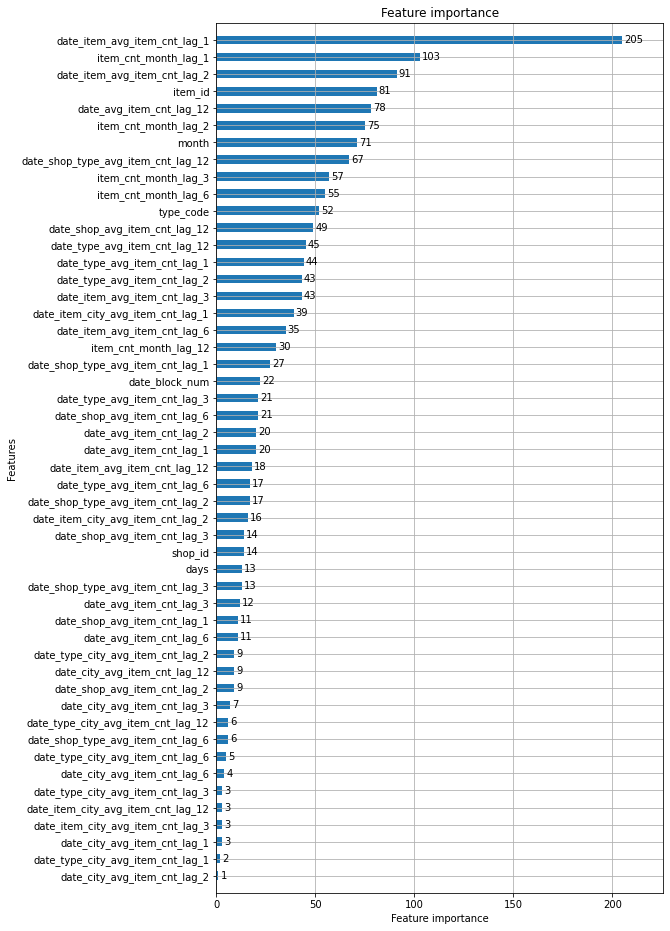

In [97]:
lgb.plot_importance(gbm, height=0.5, figsize=(8,16))